<a href="https://colab.research.google.com/github/Mollylst/resnet18/blob/main/Celebahq_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip -uq '/content/drive/MyDrive/celeb/celeb_fake.zip' -d /content/dataset
!unzip -uq '/content/drive/MyDrive/celeb/celeb_real.zip' -d /content/dataset

In [ ]:
import numpy as np
from PIL import Image
from scipy import fftpack


def dct2(array):
    array = fftpack.dct(array, type=2, norm="ortho", axis=0)
    array = fftpack.dct(array, type=2, norm="ortho", axis=1)
    return array

def log_scale(array, epsilon=1e-12):
    """Log scale the input array.
    """
    array = np.abs(array)
    array += epsilon  # no zero in log
    array = np.log(array)
    return array
    
def welford(sample):
    """Calculates the mean, variance and sample variance along the first axis of an array.
    Taken from https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
    """
    existing_aggregate = (None, None, None)
    for data in sample:
        existing_aggregate = _welford_update(existing_aggregate, data)

    # sample variance only for calculation
    return _welford_finalize(existing_aggregate)[:-1]

def welford_multidimensional(sample):
    """Same as normal welford but for multidimensional data, computes along the last axis.
    """
    aggregates = {}

    for data in sample:
        # for each sample update each axis seperately
        for i, d in enumerate(data):
            existing_aggregate = aggregates.get(i, (None, None, None))
            existing_aggregate = _welford_update(existing_aggregate, d)
            aggregates[i] = existing_aggregate

    means, variances = list(), list()

    # in newer python versions dicts would keep their insert order, but legacy
    for i in range(len(aggregates)):
        aggregate = aggregates[i]
        mean, variance = _welford_finalize(aggregate)[:-1]
        means.append(mean)
        variances.append(variance)

    return np.asarray(means), np.asarray(variances)

def _welford_update(existing_aggregate, new_value):
    (count, mean, M2) = existing_aggregate
    if count is None:
        count, mean, M2 = 0, np.zeros_like(new_value), np.zeros_like(new_value)

    count += 1
    delta = new_value - mean
    mean += delta / count
    delta2 = new_value - mean
    M2 += delta * delta2

    return (count, mean, M2)

def _welford_finalize(existing_aggregate):
    count, mean, M2 = existing_aggregate
    mean, variance, sample_variance = (mean, M2/count, M2/(count - 1))
    if count < 2:
        return (float("nan"), float("nan"), float("nan"))
    else:
        return (mean, variance, sample_variance)

def normalize(image, mean, std):
    image = (image - mean) / std
    return image

In [ ]:
import cv2
import os
import numpy as np
import random
import torch
import torchvision
import os
from torchvision import datasets 
from torch.utils.data import random_split
import torchvision.transforms as transforms

def image2npy(label2idx, dir_path='/content/dataset'):
    i = 0
    data = []
    for (root, dirs, files) in os.walk(dir_path):
        for file in files: 
            img_path = os.path.join(root, file) 
            File = root.split('/')[-1] #name of the file which is label
            #image = cv2.imread(img_path,0)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            image = np.asarray(image)
            image = dct2(image)
            image = log_scale(image)

            label = label2idx[File]
            data.append([np.asarray(image), label])
    return data

In [ ]:
label2idx = {'fake':1, 'real': 0}
data = image2npy(label2idx, dir_path='/content/dataset')

train_data,valid_data,test_data = random_split(data,[16000,2000,2000])

X_train = np.array([i[0] for i in train_data]) # train feature
X_train_max = X_train.max(0)
X_train = X_train/X_train_max
y_train = np.array([i[1] for i in train_data]) # train label

X_valid = np.array([i[0] for i in valid_data]) 
X_valid_max = X_valid.max(0)
X_valid = X_valid/X_valid_max
y_valid = np.array([i[1] for i in valid_data]) 

X_test = np.array([i[0] for i in test_data]) 
X_test_max = X_test.max(0)
X_test = X_test/X_test_max
y_test = np.array([i[1] for i in test_data]) 
print(len(X_train), len(y_train), len(X_valid), len(y_valid),len(X_test),len(y_test))

np.save('drive/MyDrive/train-images.npy', X_train)
np.save('drive/MyDrive/train-labels.npy', y_train)
np.save('drive/MyDrive/valid-images.npy', X_valid)
np.save('drive/MyDrive/valid-labels.npy', y_valid)
np.save('drive/MyDrive/test-images.npy', X_test)
np.save('drive/MyDrive/test-labels.npy', y_test)

16000 16000 2000 2000 2000 2000


Text(0.5, 1.0, 'real')

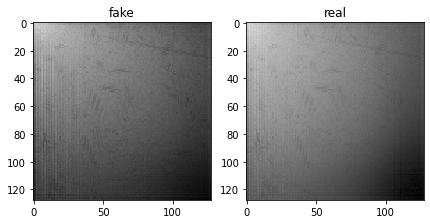

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(7,7))
axes[0].imshow(X_train[y_train==label2idx['fake']].mean(0),cmap='gray',interpolation='none')
axes[0].set_title('fake')
axes[1].imshow(X_train[y_train==label2idx['real']].mean(0),cmap='gray',interpolation='none')
axes[1].set_title('real')

In [ ]:
import torch
import torchvision
import numpy as np
from torchvision import datasets 

train_images = np.load('./drive/MyDrive/train-images.npy')
train_labels = np.load('./drive/MyDrive/train-labels.npy')
valid_images = np.load('./drive/MyDrive/valid-images.npy')
valid_labels = np.load('./drive/MyDrive/valid-labels.npy')
test_images = np.load('./drive/MyDrive/test-images.npy')
test_labels = np.load('./drive/MyDrive/test-labels.npy')

X_train = torch.from_numpy(train_images).float() 
X_valid = torch.from_numpy(valid_images).float()
X_test = torch.from_numpy(test_images).float()
Y_train = torch.from_numpy(train_labels).long() 
Y_valid = torch.from_numpy(valid_labels).long()
Y_test = torch.from_numpy(test_labels).long()

print(X_train.shape, Y_train.shape)
print(X_valid.shape, Y_valid.shape)
print(X_test.shape, Y_test.shape)

MINIBATCH_SIZE = 128

trainDataset = torch.utils.data.TensorDataset(X_train, Y_train) 
trainloader = torch.utils.data.DataLoader(
    dataset=trainDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2          # set multi-work num read data
)

image, label = iter(trainloader).next()
print(type(image), type(label))
print(image.size(), label.size())

validDataset = torch.utils.data.TensorDataset(X_valid, Y_valid) 
validloader = torch.utils.data.DataLoader(
    dataset=validDataset,
    batch_size=MINIBATCH_SIZE,
    shuffle=True,
    num_workers=2          # set multi-work num read data
)

testDataset = torch.utils.data.TensorDataset(X_test, Y_test) 
testloader = torch.utils.data.DataLoader(
    dataset=testDataset,
    batch_size=MINIBATCH_SIZE, 
    shuffle=True, 
    num_workers=2 
)

torch.Size([16000, 128, 128]) torch.Size([16000])
torch.Size([2000, 128, 128]) torch.Size([2000])
torch.Size([2000, 128, 128]) torch.Size([2000])
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([128, 128, 128]) torch.Size([128])


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [ ]:
import torch.nn as nn
input_size=16384
num_classes=2

class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        #self.mean = torch.tensor(mean)
        #self.std = torch.tensor(std)

    def forward(self, x):
        #x = x - self.mean
        #x = x / self.std
        out = self.linear(x)
        return out
 
model = LogisticRegression(input_size, num_classes).to(device)

In [ ]:
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9, weight_decay=5e-4) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=0, last_epoch=-1, verbose=False)

Epoch: 1/50
Epoch: 001, Training: Loss: 0.4487, Accuracy: 78.7937%, 
		Validation: Loss: 0.3861, Accuracy: 84.4000%, Time: 1.7008s
Best Accuracy for validation : 0.8440 at epoch 001
Epoch: 2/50
Epoch: 002, Training: Loss: 0.3350, Accuracy: 86.2250%, 
		Validation: Loss: 0.3314, Accuracy: 85.4500%, Time: 2.2551s
Best Accuracy for validation : 0.8545 at epoch 002
Epoch: 3/50
Epoch: 003, Training: Loss: 0.2899, Accuracy: 88.8812%, 
		Validation: Loss: 0.3168, Accuracy: 86.0500%, Time: 2.5766s
Best Accuracy for validation : 0.8605 at epoch 003
Epoch: 4/50
Epoch: 004, Training: Loss: 0.2591, Accuracy: 90.4937%, 
		Validation: Loss: 0.3368, Accuracy: 84.4000%, Time: 3.3136s
Best Accuracy for validation : 0.8605 at epoch 003
Epoch: 5/50
Epoch: 005, Training: Loss: 0.2460, Accuracy: 91.2438%, 
		Validation: Loss: 0.3343, Accuracy: 84.5000%, Time: 3.8782s
Best Accuracy for validation : 0.8605 at epoch 003
Epoch: 6/50
Epoch: 006, Training: Loss: 0.2187, Accuracy: 92.5125%, 
		Validation: Loss: 0

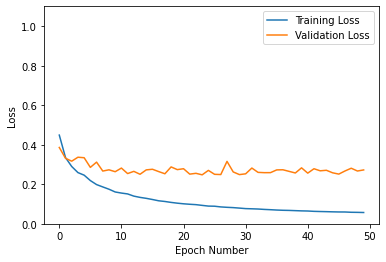

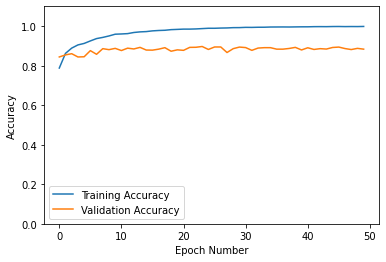

In [ ]:
import time
import matplotlib.pyplot as plt

num_epoch=50
path='./deepfake-LR.pth'

def train_and_valid():
    history = []
    best_acc = 0.0
    best_epoch = 0
    
    for epoch in range(0,num_epoch):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, num_epoch))

        model.train()
        train_loss = 0.0
        train_acc = 0.0
        valid_loss = 0.0
        valid_acc = 0.0

        #train
        for i, (inputs, labels) in enumerate(trainloader):

            inputs = inputs.reshape(-1, 128*128).to(device)
            labels = labels.to(device)  # Labels
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)

            #L1_reg = 0
            #for param in model.parameters():
              #L1_reg += torch.sum(torch.abs(param))
            #loss += 0.001 * L1_reg  # lambda=0.001
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _,predictions = torch.max(outputs.data, 1)
            train_acc += (predictions == labels).sum().item()

        #valid
        model.eval()
        with torch.no_grad():

            for j, (inputs, labels) in enumerate(validloader):

                inputs = inputs.reshape(-1, 128*128).to(device)
                labels = labels.to(device)  # Labels
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                valid_loss += loss.item() * inputs.size(0)
                _,predictions = torch.max(outputs.data, 1)
                valid_acc += (predictions == labels).sum().item()
 
        avg_train_loss = train_loss/ len(trainDataset)
        avg_train_acc = train_acc/ len(trainDataset)
 
        avg_valid_loss = valid_loss/ len(validDataset)
        avg_valid_acc = valid_acc/ len(validDataset)

        #record the accuracy and loss in each epoch
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
 
        if best_acc < avg_valid_acc:
            best_acc = avg_valid_acc
            best_epoch = epoch + 1
            torch.save(model.state_dict(),path)
        scheduler.step()  

        epoch_end = time.time()
        
        print("Epoch: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation: Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start
        ))
        print("Best Accuracy for validation : {:.4f} at epoch {:03d}".format(best_acc, best_epoch))

    return history
    
#start training and testing
history = train_and_valid()

#make the plots
history = np.array(history)
plt.plot(history[:, 0:2])
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_loss_curve.png')
plt.show()
 
plt.plot(history[:, 2:4])
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
#plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [ ]:
model.load_state_dict(torch.load(path))
correct = 0
total = 0
model.eval()
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for j, (inputs, labels) in enumerate(testloader):
        inputs = inputs.reshape(-1, 128*128).to(device)
        labels = labels.to(device)  # Labels
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 89 %
